I should write stuff here

## Notes to self
- I removed clm, numclaims. Only focusing on claimcst0. Is there a way to train the model on clm, numclaims such that it somehow improves the accuracy???
- Alot of the claimcst0 have no values and only a few have non-zero value, is there something we can do here???

### Imports & Global Variables

In [721]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# place imports back here

In [722]:
import os, sys
PATH = %pwd
PATH = PATH.split(os.path.sep)
PATH = os.path.sep.join(PATH[:-2]) #removes last 2 directories, gets path to repository

import warnings
warnings.filterwarnings("ignore", "is_sparse")

### Preprocessing

In [723]:
# (1) Read both train/test + validation & preform equal preprocessing on it
df_t = pd.read_csv(os.path.join(PATH, 'dataset', 'InsNova_data_2023_train.csv'))
df_t['is_val'] = 0
df_v = pd.read_csv(os.path.join(PATH, 'dataset', 'InsNova_data_2023_vh.csv'))
df_v['is_val'] = 1
total_df = pd.concat([df_t,df_v], ignore_index=True)

In [724]:
# Note
col_categorical = ['veh_body', 'gender', 'area', 'engine_type', 'veh_color', 
                'marital_status', 'time_of_week_driven', 'time_driven']
col_continuous = ['veh_value', 'exposure', 'credit_score']
col_discrete = ['veh_age', 'agecat', 'max_power', 'driving_history_score',
                'e_bill', 'trm_len', 'high_education_ind']

# (2) Feature Manipulation
# (2.1) Continuous/Discrete scaling

from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
df_t[col_continuous] = rs.fit_transform(df_t[col_continuous])
df_t[col_discrete] = rs.fit_transform(df_t[col_discrete])

df_v[col_continuous] = rs.fit_transform(df_v[col_continuous])
df_v[col_discrete] = rs.fit_transform(df_v[col_discrete])

# (2.2) Categorical processing
df_t = pd.get_dummies(data=df_t,columns=col_categorical, dtype=float)
df_v = pd.get_dummies(data=df_v,columns=col_categorical, dtype=float)


# Replace whitespace with underscore ' ' -> '_'
df_t.columns = df_t.columns.str.replace(' ', '_')
df_v.columns = df_v.columns.str.replace(' ', '_')


# (3) separate total_df
df_t = df_t.drop(columns=['clm','numclaims'])
df_t = df_t.reset_index(drop=True)

df_v = df_v.reset_index(drop=True)


### Issues
- Imbalanced


In [725]:
claimcst0_percentage = (len(df_t[(df_t['claimcst0'] > 0)])/len(df_t['claimcst0']))*100
print(f"df_t claimcst0 percentage: {claimcst0_percentage}%")

df_t claimcst0 percentage: 6.817277510057916%


In [726]:
df_t_zero = df_t[df_t['claimcst0'] == 0]
df_t_non_0 = df_t[df_t['claimcst0'] > 0]

print(f"zero_shape: {df_t_zero.shape} | non-zero_shape: {df_t_non_0.shape}")

zero_shape: (21077, 55) | non-zero_shape: (1542, 55)


In [727]:
'''
factor = len(df_t_zero)//len(df_t_non_0)
df_t_non_0 = factor * df_t_non_0
train_df = pd.concat([df_t_zero,df_t_non_0], axis=0)
train_df = pd.concat([df_t_zero[:df_t_non_0.shape[0]],df_t_non_0], axis=0)
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

X = df_t.drop(['id','claimcst0'], axis=1)
y = df_t['claimcst0']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Model Creation

In [728]:
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values).view(-1,1)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values).view(-1,1)

In [729]:
class Model(nn.Module):
    def __init__(self, num_categories, layer_sizes):
        super(Model, self).__init__()

        self.embedding_layer = nn.Linear(num_categories, layer_sizes[0])
        self.layers = nn.ModuleList([nn.Linear(layer_sizes[i], layer_sizes[i + 1]) for i in range(len(layer_sizes) - 1)])
        self.output_layer = nn.Linear(layer_sizes[-1], 1)

    def forward(self, x):
        x = self.embedding_layer(x)
        for layer in self.layers:
            x = F.leaky_relu(layer(x))
        x = self.output_layer(x)
        return x

In [730]:
NUM_EPOCHS = 1000
NUM_INPUT_FEATURE = X_train.shape[1]
NUM_LAYER_SIZES = [16, 16, 8, 4]
NUM_NO_VAL_LOSS_IMPROVE = 20

model = Model(NUM_INPUT_FEATURE,
              NUM_LAYER_SIZES)

criterion = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.01)

In [731]:
val_no_improve_counter = 0
best_val_loss = float('inf')

train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')
        
    #Val
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        print(f'Validation Loss: {val_loss.item():.4f}')

        if val_loss > best_val_loss:
            val_no_improve_counter += 1
            if val_no_improve_counter >= NUM_NO_VAL_LOSS_IMPROVE:
                print(f'Early stopping at epoch {epoch+1}. Validation loss stopped improving.')
                break
        else:
            best_val_loss = val_loss
            counter = 0
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

Validation Loss: 2133.2092
Validation Loss: 2133.2078
Validation Loss: 2133.2068
Validation Loss: 2133.2056
Validation Loss: 2133.2046
Validation Loss: 2133.2034
Validation Loss: 2133.2021
Validation Loss: 2133.2014
Validation Loss: 2133.2000
Epoch [10/1000], Loss: 1936.9849
Validation Loss: 2133.1990
Validation Loss: 2133.1980
Validation Loss: 2133.1968
Validation Loss: 2133.1960
Validation Loss: 2133.1948
Validation Loss: 2133.1936
Validation Loss: 2133.1924
Validation Loss: 2133.1912
Validation Loss: 2133.1902
Validation Loss: 2133.1887
Epoch [20/1000], Loss: 1936.9720
Validation Loss: 2133.1875
Validation Loss: 2133.1863
Validation Loss: 2133.1848
Validation Loss: 2133.1833
Validation Loss: 2133.1821
Validation Loss: 2133.1807
Validation Loss: 2133.1792
Validation Loss: 2133.1782
Validation Loss: 2133.1765
Validation Loss: 2133.1748
Epoch [30/1000], Loss: 1936.9572
Validation Loss: 2133.1733
Validation Loss: 2133.1809
Validation Loss: 2133.1724
Validation Loss: 2133.1729
Validation

In [732]:
with torch.no_grad():
    val_outputs = model(X_test)
    val_loss = criterion(val_outputs, y_test)
    
    val_outputs_np = val_outputs.numpy()
    y_test_np = y_test.numpy()
    
    # Print predictions and true values side by side
    for i in range(len(y_test)):
        print(f"Prediction: {val_outputs_np[i][0]:.4f}, True Value: {y_test_np[i][0]:.4f}")

    print(f'Validation Loss: {val_loss.item():.4f}')


Prediction: 0.0050, True Value: 0.0000
Prediction: 0.0051, True Value: 0.0000
Prediction: 0.0047, True Value: 0.0000
Prediction: 0.0053, True Value: 2983.1177
Prediction: 0.0052, True Value: 0.0000
Prediction: 0.0054, True Value: 0.0000
Prediction: 0.0050, True Value: 0.0000
Prediction: 0.0047, True Value: 0.0000
Prediction: 0.0050, True Value: 0.0000
Prediction: 0.0050, True Value: 0.0000
Prediction: 0.0052, True Value: 0.0000
Prediction: 0.0052, True Value: 0.0000
Prediction: 0.0048, True Value: 890.1256
Prediction: 0.0049, True Value: 0.0000
Prediction: 0.0050, True Value: 0.0000
Prediction: 0.0053, True Value: 0.0000
Prediction: 0.0048, True Value: 0.0000
Prediction: 0.0053, True Value: 0.0000
Prediction: 0.0050, True Value: 2507.1951
Prediction: 0.0049, True Value: 0.0000
Prediction: 0.0049, True Value: 0.0000
Prediction: 0.0054, True Value: 0.0000
Prediction: 0.0052, True Value: 0.0000
Prediction: 0.0050, True Value: 0.0000
Prediction: 0.0049, True Value: 0.0000
Prediction: 0.005

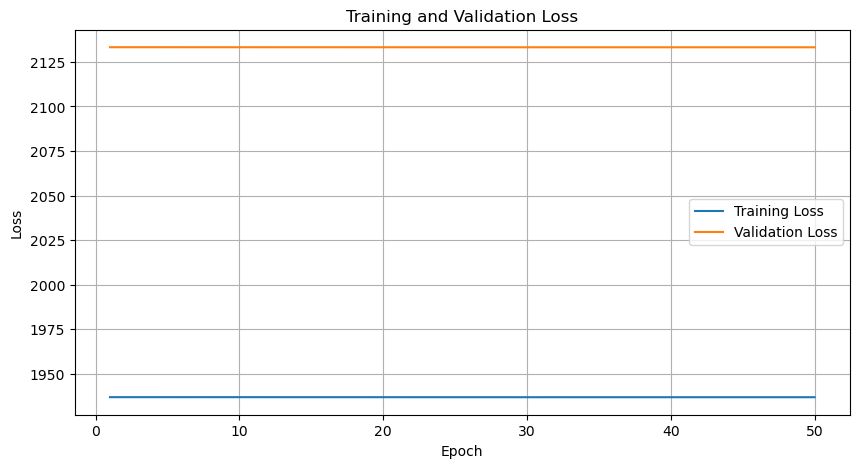

In [733]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

In [734]:
df_v = df_v.drop('id', axis=1)
val_dataset = torch.FloatTensor(df_v.values)
val_outputs = model(val_dataset)

val_outputs = torch.where((val_outputs <= 10) & (val_outputs >= -10), torch.tensor(0.0), val_outputs)
val_outputs = pd.DataFrame(val_outputs.detach().numpy(), columns=['Predict'])
val_outputs.rename_axis('id', inplace=True)
val_outputs.index += 1
val_outputs.to_csv('NN_Submission.csv', index=True)

In [735]:
def gini_coefficient(x):
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

val_outputs = model(val_dataset)
val_outputs = torch.where((val_outputs <= 10) & (val_outputs >= -10), torch.tensor(0.0), val_outputs)
val_outputs = val_outputs.tolist()
val_outputs = [int(x[0]) for x in val_outputs]
val_outputs = np.array(val_outputs)
gini_coefficient(val_outputs)

/var/folders/9x/gfsbvn8s6vg7sghytlgt5p880000gp/T/ipykernel_59800/3963836493.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return diffsum / (len(x)**2 * np.mean(x))


nan